# IRIS classification with the bivariate Gaussian

Our first generative model for IRIS classification used just one feature. Now we use two features, modeling each class by a **bivariate Gaussian**.

**Note:** You can use built-in code for mean, variance, covariance, determinant, etc.

## 1. Load in the data set

As in the univariate case, we start by loading in the IRIS data set.
Recall that there are 150 data points, each with 4 features and a label (0,1,2). As before, we will divide this into a training set of 105 points and a test set of 45 points.

In [1]:
# Standard includes
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# Useful module for dealing with the Gaussian density
from scipy.stats import norm, multivariate_normal  #in case you use buit-in library
# installing packages for interactive graphs
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
from sklearn import datasets
import time

### Loading the IRIS dataset

In [2]:
iris = datasets.load_iris()
X = iris.data
Y = iris.target
featurenames = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']

# Split 150 instances into training set (trainx, trainy) of size 105 and test set (testx, testy) of size 45
np.random.seed(0)
perm = np.random.permutation(150)
trainx = X[perm[0:105],:]
trainy = Y[perm[0:105]]
testx = X[perm[105:150],:]
testy = Y[perm[105:150]]

In [3]:
X.shape, Y.shape

((150, 4), (150,))

## 2. Look at the distribution of two features from one of the species

Our goal is to plot the distribution of two features for a particular species. We will use several helper functions for this. It is worth understanding each of these.

The first helper function fits a Gaussian to a data set, restricting attention to specified features.
It returns the mean and covariance matrix of the Gaussian.

In [4]:
# Fit a Gaussian to a data set using the selected features
def fit_gaussian(x, features):
    ### START CODE HERE ###
    mu = x[:, features].mean(axis=0)
    covar = np.cov(x[:, features], rowvar=False)

#     covar = np.zeros((len(features), len(features)))
#     for i in range(covar.shape[0]):
#         for j in range(covar.shape[1]):
#             if j==i: # diagonal
#                 covar[i,j] = np.cov x[:, features[i]] x[:, features[j]]

    ### END CODE HERE ###
    return mu, covar

For example, let's look at the Gaussian we get for species-0, using features 0 ('petal_length') and 1 ('petal_width').

In [5]:
f1 = 0
f2 = 1
label = 0
mu, covar = fit_gaussian(trainx[trainy==label,:], [f1,f2])
print ("Mean:\n" + str(mu))
print ("Covariance matrix:\n" + str(covar))

Mean:
[4.95757576 3.43030303]
Covariance matrix:
[[0.14314394 0.12413826]
 [0.12413826 0.17030303]]


Next, we will construct a routine for displaying points sampled from a two-dimensional Gaussian, as well as a few contour lines. Part of doing this involves deciding what range to use for each axis. We begin with a little helper function that takes as input an array of numbers (values along a single feature) and returns the range in which these numbers lie.

In [6]:
# Find the range within which an array of numbers lie, with a little buffer
def find_range(x):
    lower = min(x)
    upper = max(x)
    width = upper - lower
    lower = lower - 0.2 * width
    upper = upper + 0.2 * width
    return lower, upper

Next we define a routine that plots a few contour lines of a given two-dimensional Gaussian.
It takes as input:
* `mu`, `cov`: the parameters of the Gaussian
* `x1g`, `x2g`: the grid (along the two axes) at which the density is to be computed
* `col`: the color of the contour lines

In [7]:
def plot_contours(mu, cov, x1g, x2g, col):
    start_time = time.time()
    rv = multivariate_normal(mean=mu, cov=cov, allow_singular=True)
    z = np.zeros((len(x1g),len(x2g)))
    for i in range(0,len(x1g)):
        for j in range(0,len(x2g)):
            z[j,i] = rv.logpdf([x1g[i], x2g[j]]) 
    sign, logdet = np.linalg.slogdet(cov)
    normalizer = -0.5 * (2 * np.log(6.28) + sign * logdet)
    for offset in range(1,4):
        plt.contour(x1g,x2g,z, levels=[normalizer - offset], colors=col, linewidths=2.0, linestyles='solid')
    
    print('Finished in {:.2f} seconds'.format(time.time()-start_time))

The function **two_features_plot** takes an input two features and a label, and displays the distribution for the specified species and pair of features.

The first line allows you to specify the parameters interactively using sliders.

In [8]:
@interact( f1=IntSlider(0,0,3,1), f2=IntSlider(1,0,3,1), label=IntSlider(0,0,2,1) )
def two_features_plot(f1,f2,label):
    if f1 == f2: # we need f1 != f2
        print ("Please choose different features for f1 and f2.")
        return  
    
    # Set up plot
    x1_lower, x1_upper = find_range(trainx[trainy==label,f1])
    x2_lower, x2_upper = find_range(trainx[trainy==label,f2])
    plt.xlim(x1_lower, x1_upper) # limit along x1-axis
    plt.ylim(x2_lower, x2_upper) # limit along x2-axis
    
    # Plot the training points along the two selected features
    plt.plot(trainx[trainy==label, f1], trainx[trainy==label, f2], 'ro')

    # Define a grid along each axis; the density will be computed at each grid point
    res = 200 # resolution
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Now plot a few contour lines of the density
    ### UPDATE CODE HERE ###
    mu, cov = fit_gaussian(trainx[trainy==label,:], [f1, f2])
    plot_contours(mu, cov, x1g, x2g, 'k')
    
    # Finally, display
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.title('Species-' + str(label), fontsize=14, color='blue')
    plt.show()

interactive(children=(IntSlider(value=0, description='f1', max=3), IntSlider(value=1, description='f2', max=3)…

## 3. Fit a Gaussian to each class

We now define a function that will fit a Gaussian generative model to the three classes, restricted to a given list of features. The function returns:
* `mu`: the means of the Gaussians, one per row
* `covar`: covariance matrices of each of the Gaussians
* `pi`: list of three class weights summing to 1

In [9]:
# Assumes y takes on values 1,2,3
def fit_generative_model(x, y, features):
    k = 3 # number of classes
    d = len(features) # number of features
    mu = np.zeros((k,d)) # list of means
    covar = np.zeros((k,d,d)) # list of covariance matrices
    pi = np.zeros(k) # list of class weights
    for label in range(0,k):
        indices = (y==label)
        ### UPDATE CODE HERE ###        
        class_x = x[indices][features]
        
        mu[label,:], covar[label,:,:] = fit_gaussian(class_x, features)
        pi[label] = class_x.shape[0] / x[:, features].shape[0]  # the prior
    return mu, covar, pi

Now we will plot the three Gaussians.

In [10]:
@interact( f1=IntSlider(0,0,3,1), f2=IntSlider(1,0,3,1) )
def three_class_plot(f1,f2):
    if f1 == f2: # we need f1 != f2
        print ("Please choose different features for f1 and f2.")
        return  
    
    # Set up plot
    x1_lower, x1_upper = find_range(trainx[:,f1])
    x2_lower, x2_upper = find_range(trainx[:,f2])
    plt.xlim(x1_lower, x1_upper) # limit along x1-axis
    plt.ylim(x2_lower, x2_upper) # limit along x2-axis
    
    # Plot the training points along the two selected features
    colors = ['r', 'y', 'g']
    for label in range(0,3):
        plt.plot(trainx[trainy==label,f1], trainx[trainy==label,f2], marker='o', ls='None', c=colors[label-1])

    # Define a grid along each axis; the density will be computed at each grid point
    res = 200 # resolution
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Show the Gaussian fit to each class, using features f1,f2
    ### UPDATE CODE HERE ###
    mu, covar, pi = fit_generative_model(trainx, trainy, [f1, f2])
    for label in range(0,3):
        gmean = mu[label,:]
        gcov = covar[label,:,:]
        # ERROR: gcov is singular
        plot_contours(gmean, gcov, x1g, x2g, colors[label-1])

    # Finally, display
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.title('IRIS data', fontsize=14, color='blue')
    plt.show()

interactive(children=(IntSlider(value=0, description='f1', max=3), IntSlider(value=1, description='f2', max=3)…

## 4. Predict labels for the test points

How well we can predict the class (1,2,3) based just on these two features?

We start with a testing procedure that is analogous to what we developed in the 1-d case.

In [12]:
def predict(mu, var, pi, testx, feature):
    n_test = testx.shape[0] # Number of test points
    k = 3 # Labels 0,1,2,...,k
    score = np.zeros((n_test, k)) # [test, label]

    for i in range(0, n_test):
        for label in range(0, k):
            ### START CODE HERE ###
            # Implement the formula for normal pdf. 
            p = np.exp(- (testx[i, feature] - mu[label])**2 / (2*var[label]) ) \
                / np.sqrt(2.0*np.pi*var[label])
            
#             p = norm.logpdf(testx[i, feature], loc=mu[label], scale=var[label])
        
            score[i, label] = np.mean( pi[label] * p )
    
    predictions = np.argmax(score, axis=1) #think about using np.argmax on score[]
    ### END CODE HERE ###
    return predictions

In [28]:
# Now test the performance of a predictor based on a subset of features
# @interact( f1=IntSlider(0,0,3,1), f2=IntSlider(1,0,3,1) )
def test_model(f1, f2, testx=testx, testy=testy):
    if f1 == f2: # need f1 != f2
        print ("Please choose different features for f1 and f2.")
        return  
    features= [f1,f2]
    ### UPDATE CODE HERE ###
    mu, covar, pi = fit_generative_model(testx, testy, features)
    nt = len(testy) # Number of test points

    ### predict function, see above cell
    predictions = predict(mu, covar, pi, testx, features)
    
    ### END CODE HERE ###
    # Finally, tally up score
    errors = np.sum(predictions != testy)
    print ("Test error using feature(s): ", end='')
    for f in features:
        print ("'" + featurenames[f] + "'" + " ", end='')
    print
    print ("Errors: " + str(errors) + "/" + str(nt))# Now test the performance of a predictor based on a subset of features
    
    return errors/nt

Test error using feature(s): 'petal_length' 'petal_width' Errors: 42/105
Test error using feature(s): 'petal_length' 'sepal_length' Errors: 15/105
Test error using feature(s): 'petal_length' 'sepal_width' Errors: 67/105
Test error using feature(s): 'petal_width' 'sepal_length' Errors: 72/105
Test error using feature(s): 'petal_width' 'sepal_width' Errors: 72/105
Test error using feature(s): 'sepal_length' 'sepal_width' Errors: 72/105


C:\Users\Faris\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


<BarContainer object of 6 artists>

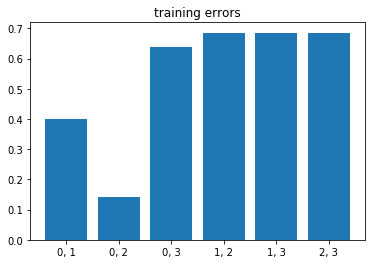

In [41]:
import itertools

scores = {}
for _1,_2 in itertools.combinations(enumerate(featurenames), 2):
    i1,f1 = _1
    i2,f2 = _2

    scores[f'{i1}, {i2}'] = test_model(i1,i2, trainx, trainy)

# print(scores)
plt.title('training errors')
plt.bar(scores.keys(), scores.values())

Test error using feature(s): 'petal_length' 'petal_width' Errors: 11/45
Test error using feature(s): 'petal_length' 'sepal_length' Errors: 28/45
Test error using feature(s): 'petal_length' 'sepal_width' Errors: 28/45
Test error using feature(s): 'petal_width' 'sepal_length' Errors: 28/45
Test error using feature(s): 'petal_width' 'sepal_width' Errors: 28/45
Test error using feature(s): 'sepal_length' 'sepal_width' Errors: 28/45


C:\Users\Faris\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Faris\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Faris\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Faris\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


<BarContainer object of 6 artists>

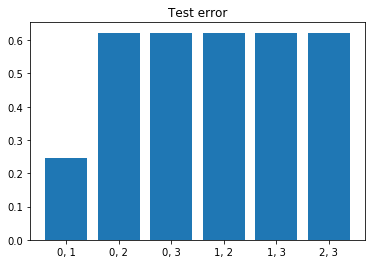

In [43]:
import itertools

scores = {}
for _1,_2 in itertools.combinations(enumerate(featurenames), 2):
    i1,f1 = _1
    i2,f2 = _2

    scores[f'{i1}, {i2}'] = test_model(i1,i2, testx, testy)

# print(scores)
plt.title('Test error')
plt.bar(scores.keys(), scores.values())

### Qusetions:

Different pairs of features yield different test errors.
1. What is the smallest achievable test error?
2. Which pair of features achieves this minimum test error?

## 5. The decision boundary 

The function **show_decision_boundary** takes as input two features, builds a classifier based only on these two features, and shows a plot that contains both the training data and the decision boundary.

To compute the decision boundary, a dense grid is defined on the two-dimensional input space and the classifier is applied to every grid point. The built-in `pyplot.contour` function can then be invoked to depict the boundary.

In [44]:
def show_decision_boundary(f1,f2):
    # Fit Gaussian to each class
    ### UPDATE CODE HERE ###
    mu, covar, pi = fit_generative_model(trainx, trainy, [f1,f2])
    
    # Set up dimensions of plot
    x1_lower, x1_upper = find_range(trainx[:,f1])
    x2_lower, x2_upper = find_range(trainx[:,f2])
    plt.xlim([x1_lower,x1_upper])
    plt.ylim([x2_lower,x2_upper])

    # Plot points in training set
    colors = ['r', 'k', 'g']
    for label in range(0,3):
        plt.plot(trainx[trainy==label,f1], trainx[trainy==label,f2], marker='o', ls='None', c=colors[label])

    # Define a dense grid; every point in the grid will be classified according to the generative model
    res = 200
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Declare random variables corresponding to each class density
    random_vars = {}
    for label in range(0,3):
        random_vars[label] = multivariate_normal(mean=mu[label,:],cov=covar[label,:,:])

    # Classify every point in the grid; these are stored in an array Z[]
    Z = np.zeros((len(x1g), len(x2g)))
    for i in range(0,len(x1g)):
        for j in range(0,len(x2g)):
            scores = []
            for label in range(0,3):
                scores.append(np.log(pi[label]) + random_vars[label].logpdf([x1g[i],x2g[j]]))
            Z[i,j] = np.argmax(scores) + 1

    # Plot the contour lines
    plt.contour(x1g,x2g,Z.T,3,cmap='seismic')
    
    # Finally, show the image
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.show()

Let's use the function above to draw the decision boundary using features 0 ('alcohol') and 6 ('flavanoids').

LinAlgError: singular matrix

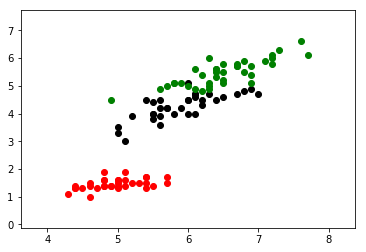

In [45]:
show_decision_boundary(0,2)

### Question

Can you add interactive sliders to function **show_decision_boundary**?

### Question

Produce a plot similar to that of **show_decision_boundary**, but in which just the **test** data is shown.
Look back at your answer to *Fast exercise 1*. Is it corroborated by your plot? Are the errors clearly visible?